# Import libraries

In [66]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import functools
import itertools
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Rectangle
from scipy.stats import wilcoxon, kendalltau
from scipy.stats import mannwhitneyu
from utils import plot_longitudinal, get_diversity

# Set constants

In [67]:
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

# Load data

In [68]:
study = "P106"

In [69]:
gmhi2 = load(os.path.join(config.MODEL_DIR, "gmhi2_model.joblib"))
gmhi2

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [70]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features_val.csv"), index_col=[0, 1]).loc[study]
print(X.shape)
X.head()

(93, 3200)


,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Thermoplasmata,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Hordeivirus|s__Barley_stripe_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cactus_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cucumber_green_mottle_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Paprika_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Pepper_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Tobacco_mild_green_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Deep_sea_thermophilic_phage_D6E,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Loktanella_phage_pCB2051_A,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Tetraselmis_viridis_virus_S1
Sample Accession,,,,,,,,,,,,,,,,,,,,,
SAMEA7082340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082341,0.018776,0.018776,0.018776,0.018776,0.018776,0.018776,0.018776,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082342,0.013714,0.013714,0.013714,0.013714,0.013714,0.013714,0.013714,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
meta = pd.read_csv(os.path.join(config.RAW_DIR, "P106_meta.csv"), index_col=[0], header=None)
meta.columns = ["desc", "id"]
meta

,desc,id
0,,
SAMEA7082433,donor,D-9Fryst_S2
SAMEA7082432,donor,D-9Feresk_S9
SAMEA7082431,donor,D-7Fryst_S7
SAMEA7082430,donor,D-6Fryst_S4
SAMEA7082429,donor,D-6Fresk_S5
...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6
SAMEA7082343,0 months-NO-Effect,12-0_S7
SAMEA7082342,6 months-Effect,11-6_S8


In [72]:
meta["group"] = meta["desc"].apply(lambda x : "donor" if x == "donor" else "no effect" if x.endswith("NO-Effect") else "effect")
meta

,desc,id,group
0,,,
SAMEA7082433,donor,D-9Fryst_S2,donor
SAMEA7082432,donor,D-9Feresk_S9,donor
SAMEA7082431,donor,D-7Fryst_S7,donor
SAMEA7082430,donor,D-6Fryst_S4,donor
SAMEA7082429,donor,D-6Fresk_S5,donor
...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect
SAMEA7082342,6 months-Effect,11-6_S8,effect


In [73]:
meta["timepoint"] = meta["desc"].apply(lambda x : -1 if x == "donor" else int(x[:2]))
meta

,desc,id,group,timepoint
0,,,,
SAMEA7082433,donor,D-9Fryst_S2,donor,-1
SAMEA7082432,donor,D-9Feresk_S9,donor,-1
SAMEA7082431,donor,D-7Fryst_S7,donor,-1
SAMEA7082430,donor,D-6Fryst_S4,donor,-1
SAMEA7082429,donor,D-6Fresk_S5,donor,-1
...,...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect,12
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect,0
SAMEA7082342,6 months-Effect,11-6_S8,effect,6


In [74]:
X = X.loc[meta.index]

In [75]:
assert((meta.index == X.index).all())
meta["GMHI2"] = gmhi2.decision_function(X > config.PRESENCE_CUTOFF)
meta

,desc,id,group,timepoint,GMHI2
0,,,,,
SAMEA7082433,donor,D-9Fryst_S2,donor,-1,0.658469
SAMEA7082432,donor,D-9Feresk_S9,donor,-1,0.240047
SAMEA7082431,donor,D-7Fryst_S7,donor,-1,1.355348
SAMEA7082430,donor,D-6Fryst_S4,donor,-1,1.102286
SAMEA7082429,donor,D-6Fresk_S5,donor,-1,0.863733
...,...,...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect,12,1.572111
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect,0,1.476570
SAMEA7082342,6 months-Effect,11-6_S8,effect,6,0.597960


In [76]:
meta = get_diversity(meta, X)
meta

/Users/daniel/opt/anaconda3/envs/gmwi2_analysis/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity
0,,,,,,,,
SAMEA7082433,donor,D-9Fryst_S2,donor,-1,0.658469,63,2.731925,0.089670
SAMEA7082432,donor,D-9Feresk_S9,donor,-1,0.240047,50,1.747606,0.337830
SAMEA7082431,donor,D-7Fryst_S7,donor,-1,1.355348,70,2.420487,0.161644
SAMEA7082430,donor,D-6Fryst_S4,donor,-1,1.102286,54,2.749086,0.086027
SAMEA7082429,donor,D-6Fresk_S5,donor,-1,0.863733,64,3.021262,0.063898
...,...,...,...,...,...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect,12,1.572111,84,2.944088,0.097194
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect,0,1.476570,84,3.420449,0.046836
SAMEA7082342,6 months-Effect,11-6_S8,effect,6,0.597960,78,2.601736,0.130187


In [77]:
donor_df = meta[meta["group"] == "donor"][["GMHI2", "Species Richness", "Shannon Diversity"]]
donor_df.to_csv(os.path.join(config.FIG_DATA_DIR, "2c_donor.csv"))
donor_df

,GMHI2,Species Richness,Shannon Diversity
0,,,
SAMEA7082433,0.658469,63,2.731925
SAMEA7082432,0.240047,50,1.747606
SAMEA7082431,1.355348,70,2.420487
SAMEA7082430,1.102286,54,2.749086
SAMEA7082429,0.863733,64,3.021262
SAMEA7082428,0.908956,64,2.432200
SAMEA7082427,1.143303,76,2.396555
SAMEA7082426,1.221379,77,2.944291
SAMEA7082425,1.080095,78,2.547137


In [78]:
meta = meta[meta["desc"] != "donor"]
meta

,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity
0,,,,,,,,
SAMEA7082416,6 months-Effect,90-6_S9,effect,6,2.361107,70,2.957032,0.070021
SAMEA7082415,12 months-Effect,90-12_S8,effect,12,1.468948,81,2.877896,0.083205
SAMEA7082414,0 months-Effect,90-0_S4,effect,0,1.219487,68,2.611362,0.108119
SAMEA7082413,6 months-Effect,89-6_S11,effect,6,0.583346,89,2.902013,0.052669
SAMEA7082412,12 months-Effect,89-12_S9,effect,12,2.263538,65,2.572868,0.107847
...,...,...,...,...,...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect,12,1.572111,84,2.944088,0.097194
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect,0,1.476570,84,3.420449,0.046836
SAMEA7082342,6 months-Effect,11-6_S8,effect,6,0.597960,78,2.601736,0.130187


# Compute GMHI2 scores

In [79]:
meta["subject"] = meta["id"].apply(lambda x : int(x.split("-")[0]) if "-" in x else int(x.split("_")[0]))
meta

/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_46089/3535871970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["subject"] = meta["id"].apply(lambda x : int(x.split("-")[0]) if "-" in x else int(x.split("_")[0]))


,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,subject
0,,,,,,,,,
SAMEA7082416,6 months-Effect,90-6_S9,effect,6,2.361107,70,2.957032,0.070021,90
SAMEA7082415,12 months-Effect,90-12_S8,effect,12,1.468948,81,2.877896,0.083205,90
SAMEA7082414,0 months-Effect,90-0_S4,effect,0,1.219487,68,2.611362,0.108119,90
SAMEA7082413,6 months-Effect,89-6_S11,effect,6,0.583346,89,2.902013,0.052669,89
SAMEA7082412,12 months-Effect,89-12_S9,effect,12,2.263538,65,2.572868,0.107847,89
...,...,...,...,...,...,...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect,12,1.572111,84,2.944088,0.097194,12
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect,0,1.476570,84,3.420449,0.046836,12
SAMEA7082342,6 months-Effect,11-6_S8,effect,6,0.597960,78,2.601736,0.130187,11


In [80]:
meta

,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,subject
0,,,,,,,,,
SAMEA7082416,6 months-Effect,90-6_S9,effect,6,2.361107,70,2.957032,0.070021,90
SAMEA7082415,12 months-Effect,90-12_S8,effect,12,1.468948,81,2.877896,0.083205,90
SAMEA7082414,0 months-Effect,90-0_S4,effect,0,1.219487,68,2.611362,0.108119,90
SAMEA7082413,6 months-Effect,89-6_S11,effect,6,0.583346,89,2.902013,0.052669,89
SAMEA7082412,12 months-Effect,89-12_S9,effect,12,2.263538,65,2.572868,0.107847,89
...,...,...,...,...,...,...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect,12,1.572111,84,2.944088,0.097194,12
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect,0,1.476570,84,3.420449,0.046836,12
SAMEA7082342,6 months-Effect,11-6_S8,effect,6,0.597960,78,2.601736,0.130187,11


In [81]:
subject_counts = meta.groupby("subject")["subject"].count()
in_all_timepoints = list(subject_counts[subject_counts >= 3].index)

In [82]:
meta = meta[meta["subject"].isin(in_all_timepoints)]

In [83]:
# for some reason, subject 16 has 5 samples. remove duplicates
sample_16_duplicates = ["SAMEA7082348", "SAMEA7082346"]
meta = meta.drop(labels=sample_16_duplicates)

meta.shape

(66, 9)

In [84]:
meta[["group"]].to_csv(os.path.join(config.LOG_DIR, "fmt_effect_noeffect.csv"))

In [94]:
meta[(meta["group"] == "effect") & (meta["timepoint"] == 0)]

,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,subject
0,,,,,,,,,
SAMEA7082414,0 months-Effect,90-0_S4,effect,0,1.219487,68,2.611362,0.108119,90
SAMEA7082411,0 months-Effect,89-0_S2,effect,0,-0.535925,78,2.450486,0.112708,89
SAMEA7082408,0 months-Effect,88-0_S4,effect,0,2.242830,69,2.700168,0.078924,88
SAMEA7082404,0 months-Effect,78-0_S8,effect,0,1.480539,72,1.844365,0.294692,78
SAMEA7082401,0 months-Effect,77-0_S5,effect,0,-1.458950,95,2.932706,0.085432,77
SAMEA7082387,0 months-Effect,59-0_S4,effect,0,-0.133333,79,2.667012,0.080368,59
SAMEA7082374,0 months-Effect,31-0_S9,effect,0,2.153703,74,2.857695,0.051869,31
SAMEA7082371,0 months-Effect,30-0_S8,effect,0,1.878644,81,2.824475,0.068170,30
SAMEA7082368,0 months-Effect,3-0_S1,effect,0,1.971127,70,2.728432,0.070920,3


In [98]:
meta[(meta["group"] == "no effect") & (meta["timepoint"] == 6)]

,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,subject
0,,,,,,,,,
SAMEA7082400,6 months-NO-Effect,75-6_S5,no effect,6,1.317196,57,2.426521,0.126189,75
SAMEA7082395,6 months-NO-Effect,66-6_S2,no effect,6,1.505395,87,3.082560,0.060776,66
SAMEA7082392,6 months-NO-Effect,64-6_S9,no effect,6,1.005344,80,3.072602,0.069467,64
SAMEA7082386,6 months-NO-Effect,56-6_S7,no effect,6,0.270243,76,3.100071,0.063161,56
SAMEA7082379,6 months-NO-Effect,32-6_S5,no effect,6,1.807143,67,2.779626,0.084721,32
SAMEA7082360,6 months-NO-Effect,22-6_S3,no effect,6,1.985585,77,2.589958,0.133166,22
SAMEA7082353,6 months-NO-Effect,18-6_S1,no effect,6,1.002959,51,1.298965,0.025878,18
SAMEA7082345,6 months-NO-Effect,12-6_S10,no effect,6,0.141230,103,2.377053,0.182184,12


# Compute other indices

In [48]:
X = X.loc[meta.index]

In [49]:
assert((meta.index == X.index).all())
meta["GMHI2"] = gmhi2.decision_function(X > config.PRESENCE_CUTOFF)
meta

,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,subject
0,,,,,,,,,
SAMEA7082416,6 months-Effect,90-6_S9,effect,6,2.361107,70,2.957032,0.070021,90
SAMEA7082415,12 months-Effect,90-12_S8,effect,12,1.468948,81,2.877896,0.083205,90
SAMEA7082414,0 months-Effect,90-0_S4,effect,0,1.219487,68,2.611362,0.108119,90
SAMEA7082413,6 months-Effect,89-6_S11,effect,6,0.583346,89,2.902013,0.052669,89
SAMEA7082412,12 months-Effect,89-12_S9,effect,12,2.263538,65,2.572868,0.107847,89
...,...,...,...,...,...,...,...,...,...
SAMEA7082344,12 months-NO-Effect,12-12_S6,no effect,12,1.572111,84,2.944088,0.097194,12
SAMEA7082343,0 months-NO-Effect,12-0_S7,no effect,0,1.476570,84,3.420449,0.046836,12
SAMEA7082342,6 months-Effect,11-6_S8,effect,6,0.597960,78,2.601736,0.130187,11


In [50]:
# def get_diversity(meta, X):
#     X_species = X[[col for col in X.columns if "s__" in col]]
#     keep = X_species.mean() > 0.00001
#     X_species = X_species.iloc[:, keep.values.flatten()]
    
#     meta = meta.copy()
#     meta["Species Richness"] = np.sum(X_species > config.PRESENCE_CUTOFF, axis=1).values
#     meta["Shannon Diversity"] = np.sum(-1 * (X_species * np.log(X_species)).fillna(0).values, axis=1)
#     meta["Simpson Diversity"] = np.sum((X_species ** 2).values, axis=1)
#     return meta

In [51]:
old_meta = meta.copy()
meta = old_meta.copy()
meta = get_diversity(meta, X)

/Users/daniel/opt/anaconda3/envs/gmwi2_analysis/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [52]:
# meta = get_diversity(meta, X)
# meta.head()

In [53]:
meta.shape

(66, 9)

In [54]:
meta["timepoint_plot"] = [int(time) for time in meta["timepoint"]]
meta["timepoint_plot"] = meta["timepoint_plot"].apply(lambda x : {0 : 0, 6 : 1, 12 : 2}[x])
meta.head()

,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,subject,timepoint_plot
0,,,,,,,,,,
SAMEA7082416,6 months-Effect,90-6_S9,effect,6,2.361107,70,2.957032,0.070021,90,1
SAMEA7082415,12 months-Effect,90-12_S8,effect,12,1.468948,81,2.877896,0.083205,90,2
SAMEA7082414,0 months-Effect,90-0_S4,effect,0,1.219487,68,2.611362,0.108119,90,0
SAMEA7082413,6 months-Effect,89-6_S11,effect,6,0.583346,89,2.902013,0.052669,89,1
SAMEA7082412,12 months-Effect,89-12_S9,effect,12,2.263538,65,2.572868,0.107847,89,2


In [55]:
indices = ["GMHI2", "Species Richness", "Shannon Diversity", "Simpson Diversity"]

In [56]:
meta.index = meta["subject"]
meta

,desc,id,group,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,subject,timepoint_plot
subject,,,,,,,,,,
90,6 months-Effect,90-6_S9,effect,6,2.361107,70,2.957032,0.070021,90,1
90,12 months-Effect,90-12_S8,effect,12,1.468948,81,2.877896,0.083205,90,2
90,0 months-Effect,90-0_S4,effect,0,1.219487,68,2.611362,0.108119,90,0
89,6 months-Effect,89-6_S11,effect,6,0.583346,89,2.902013,0.052669,89,1
89,12 months-Effect,89-12_S9,effect,12,2.263538,65,2.572868,0.107847,89,2
...,...,...,...,...,...,...,...,...,...,...
12,12 months-NO-Effect,12-12_S6,no effect,12,1.572111,84,2.944088,0.097194,12,2
12,0 months-NO-Effect,12-0_S7,no effect,0,1.476570,84,3.420449,0.046836,12,0
11,6 months-Effect,11-6_S8,effect,6,0.597960,78,2.601736,0.130187,11,1


In [57]:
meta = meta[meta["timepoint"] != 12]

In [58]:
timepoints_sorted = sorted(list(meta["timepoint"].unique()), key=lambda x : int(x))
timepoints_sorted

[0, 6]

/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:49: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  timepoint_df = timepoint_df.loc[subjects_in_both]
/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:50: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  baseline_df_curr = baseline_df.loc[subjects_in_both]
/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:49: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  timepoint_df = timepoint_df.loc[subjects_in_both]
/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:50: FutureWarning: Passing a set as an indexer is deprecated and w

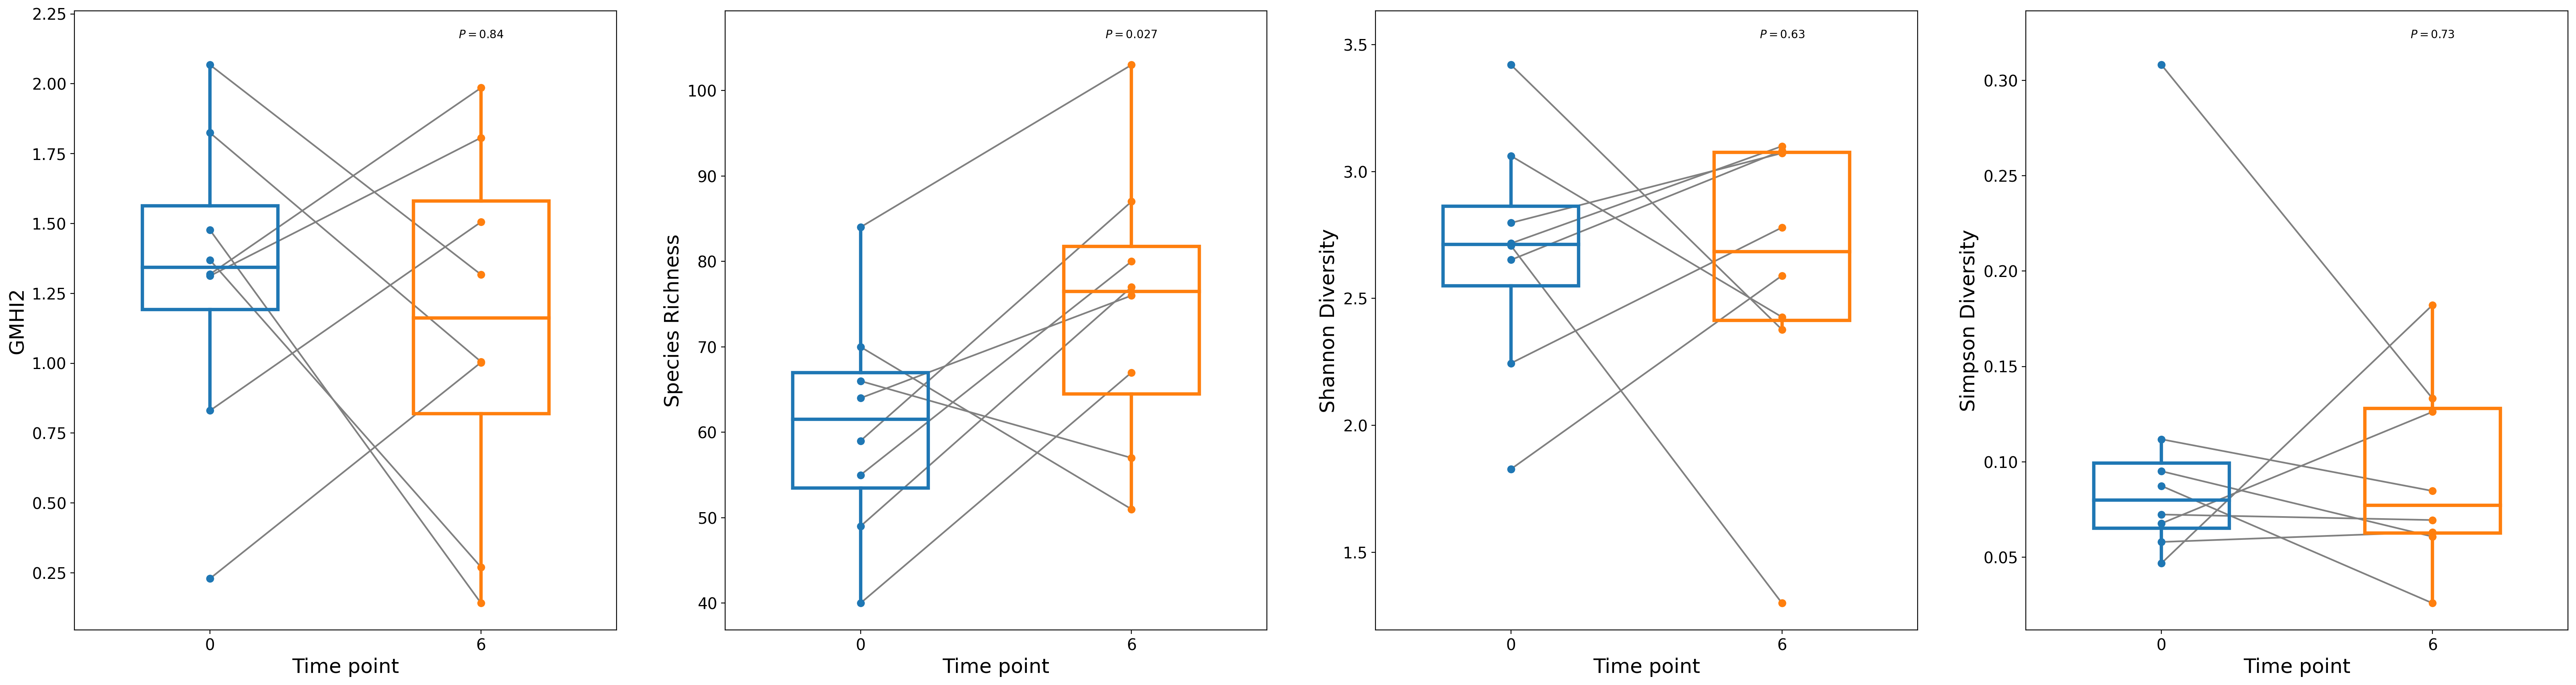

In [59]:
plot_longitudinal(meta[meta["group"] == "no effect"], indices, timepoints_sorted, study + "_no_effect", alternative="less")

In [64]:
no_effect_df = meta[meta["group"] == "no effect"][["GMHI2", "Species Richness", "Shannon Diversity", "timepoint"]]
no_effect_df

,GMHI2,Species Richness,Shannon Diversity,timepoint
subject,,,,
75,1.317196,57,2.426521,6
75,2.067763,66,3.061683,0
66,1.505395,87,3.082560,6
66,0.830505,59,2.651931,0
64,1.005344,80,3.072602,6
64,1.824617,55,2.797719,0
56,0.270243,76,3.100071,6
56,1.369161,64,2.716997,0
32,1.807143,67,2.779626,6


In [65]:
no_effect_df.to_csv(os.path.join(config.FIG_DATA_DIR, "2c_noeffect.csv"))

/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:49: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  timepoint_df = timepoint_df.loc[subjects_in_both]
/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:50: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  baseline_df_curr = baseline_df.loc[subjects_in_both]
/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:49: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  timepoint_df = timepoint_df.loc[subjects_in_both]
/Users/daniel/Documents/School/2020-2021/Spring/Research/GMHI2-analysis-clean/manuscript_raw/src/utils.py:50: FutureWarning: Passing a set as an indexer is deprecated and w

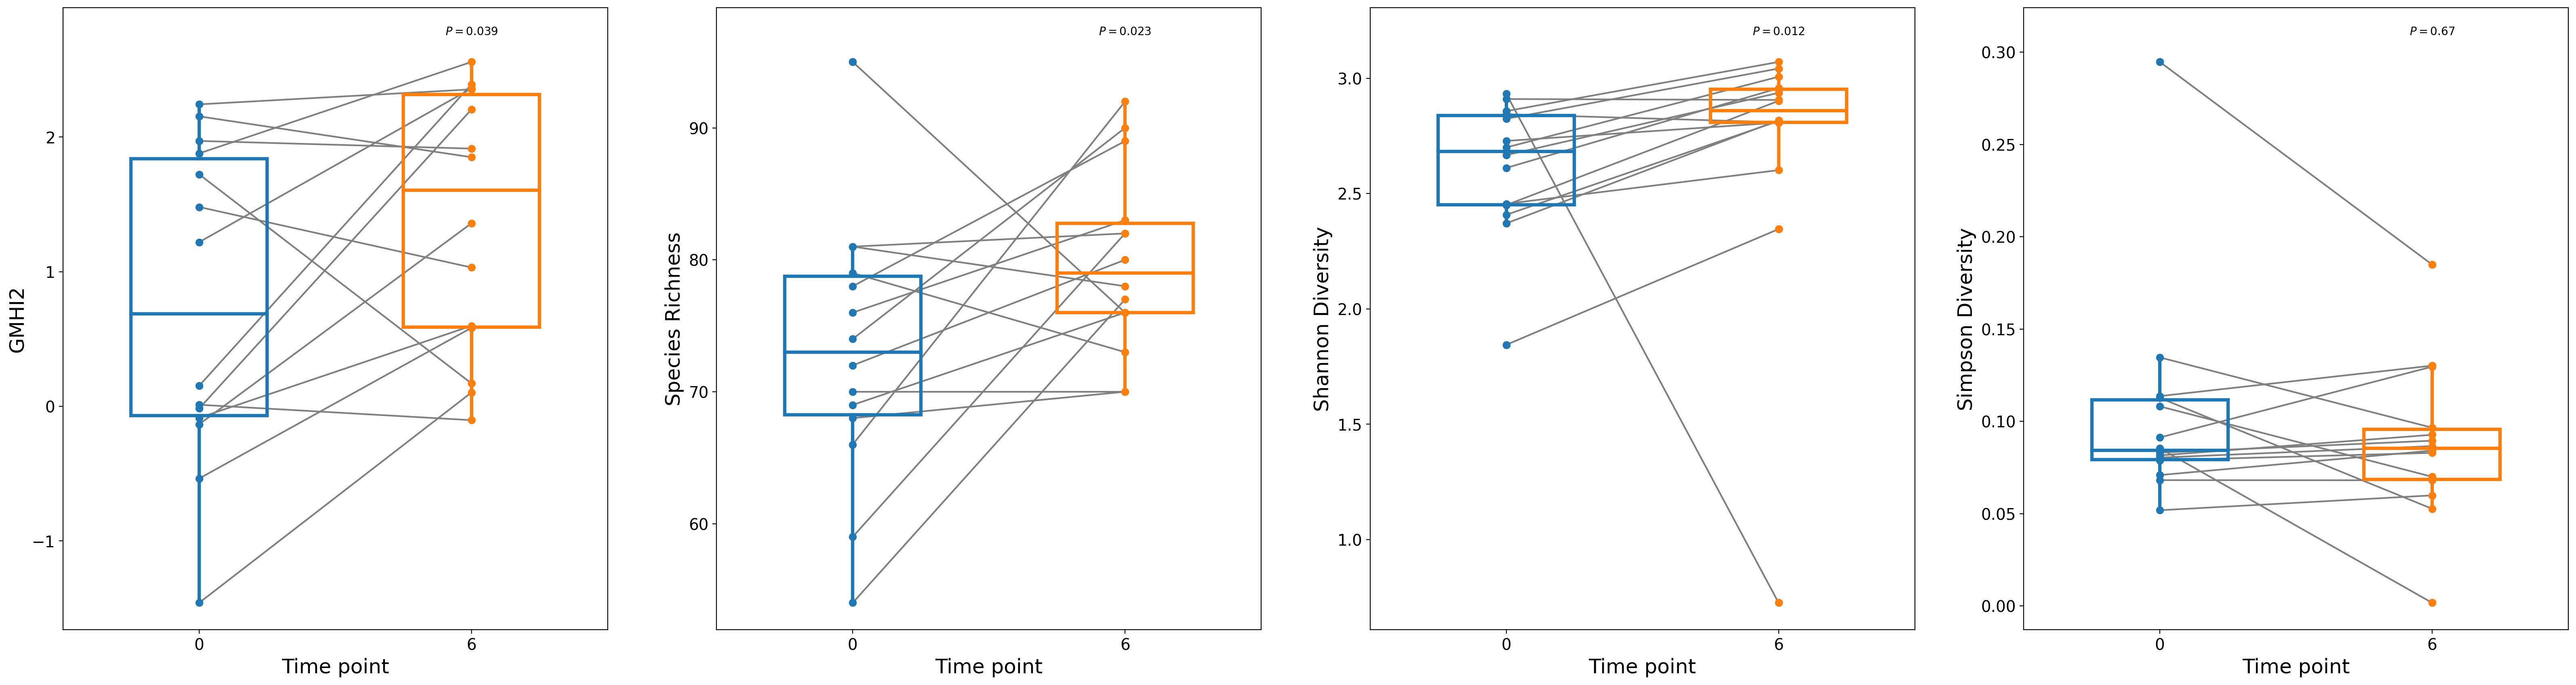

In [60]:
plot_longitudinal(meta[meta["group"] == "effect"], indices, timepoints_sorted, study + "_effect", alternative="less")

In [63]:
efg = meta[meta["group"] == "effect"]
wilcoxon(efg[efg["timepoint"] == 0]["GMHI2"], efg[efg["timepoint"] == 6]["GMHI2"], alternative="less")

WilcoxonResult(statistic=24.0, pvalue=0.03924560546875)

In [67]:
effect_df = meta[meta["group"] == "effect"][["GMHI2", "Species Richness", "Shannon Diversity", "timepoint"]]
effect_df

,GMHI2,Species Richness,Shannon Diversity,timepoint
subject,,,,
90,2.361107,70,2.957032,6
90,1.219487,68,2.611362,0
89,0.583346,89,2.902013,6
89,-0.535925,78,2.450486,0
88,2.354115,76,3.006696,6
88,2.242830,69,2.700168,0
78,1.031209,80,2.346084,6
78,1.480539,72,1.844365,0
77,0.103116,76,0.725859,6


In [68]:
effect_df.to_csv(os.path.join(config.FIG_DATA_DIR, "2c_effect.csv"))

In [72]:
effect_df.shape, no_effect_df.shape

((28, 4), (16, 4))